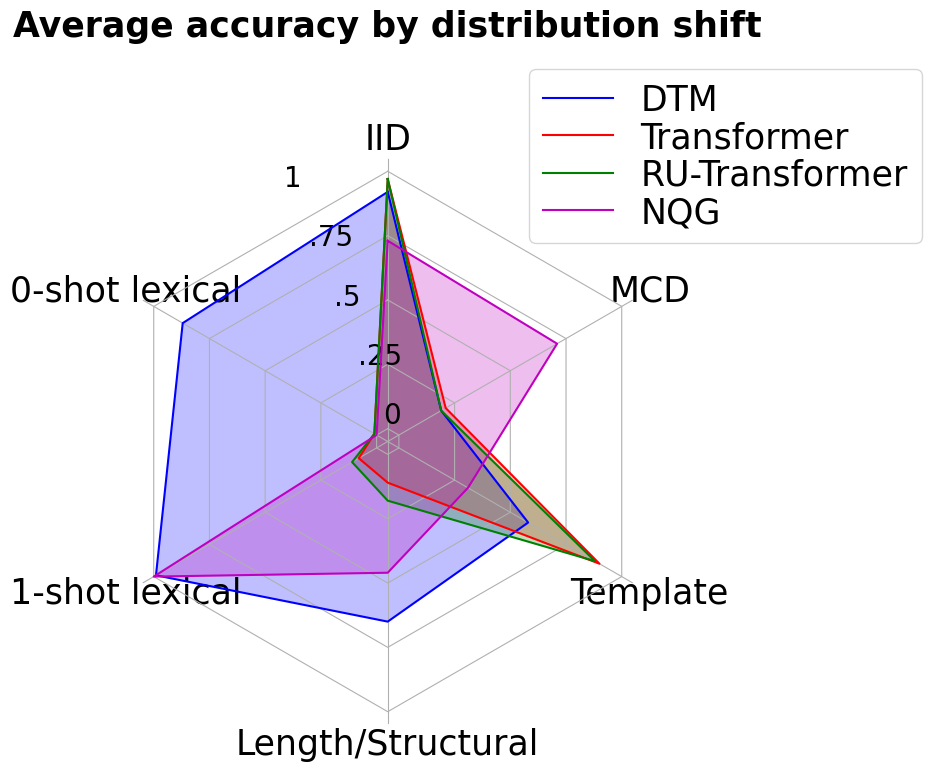

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels, fontsize='large'):
            self.set_thetagrids(np.degrees(theta), labels, fontsize=fontsize)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                spine.set_visible(False)  # Set the visibility of the spine to False
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    
    # What consolidated points do we want? IID, One-shot lexical, zero-shot lexical, structural/length, template, MCD
    data = [
        ['IID', '0-shot lexical', '1-shot lexical', 'Length/Structural', 'Template', 'MCD',],
        [
            [.92, .87, .99, .65, .58, .19],   # DTM
            [.97, .01, .08, .11, .90, 0.21], # Transformer
            [.97, .01, .11, .18, .88, .19], # RU-Transformer
            [.73, 0, 1, .46, .31, .71], # NQG doesn't include For2lam
        ],
    ]

    columns = data[0]
    values = data[1]
    df = pd.DataFrame(values, columns=columns)
    df.index = ['DTM', 'Transformer', 'RU-Transformer', 'NQG',]
    

    
    #df = df.reindex(columns=['Active↔Logical Lexical', 'Active↔Logical Structural', 'SCAN Lexical', 'SCAN Length', 'SCAN MCD', 'SCAN Template', 'For2Lam IID', ])
    return df


if __name__ == '__main__':
    N = 6
    theta = radar_factory(N, frame='polygon')

    df = example_data()
    data = df.values

    fontsize=25
    
    jitter = .2
    data = data + jitter
    
    spoke_labels = df.columns

    fig, axs = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm']# 'y']
    # Plot the four cases from the example data on separate axes
    #for ax, (title, case_data) in zip(axs.flat, data):
    ax = axs
    title = 'Average accuracy by distribution shift\n\n'
    case_data = data
    ax.set_rgrids([0 + jitter, .25 + jitter, .5 + jitter, .75 + jitter, 1 + jitter], labels=['0', '.25', '.5', '.75', '1'], fontsize=fontsize-5)
    ax.set_title(title, weight='bold', size=fontsize, position=(0.5, 0),
                 horizontalalignment='center', verticalalignment='top')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels, fontsize=fontsize)

    # add legend relative to top-left plot
    labels = df.index#('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4',)
    legend = axs.legend(labels, loc=(0.75, .85),
                              labelspacing=0.1, fontsize=fontsize)

    plt.tight_layout()
    plt.savefig('radar.pdf')
    plt.savefig('radar.svg')
    plt.show()
